In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

Ridge regression __shrinks parameter estimates, but the estimates never reach exactly 0.__  **LASSO** (Least Absolute Shrinkage and Selection Operator), on the other hand, is a model optimization mechanic that works __by trying to force small parameter estimates to be equal to zero, effectively dropping them from the model.__  This can __prevent overfitting,__ and also works as an embedded __feature selection method.__  Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and __need to optimize processor time,__ or when you want to arrive at a __simpler solution that is easier to interpret.__

The cost function to minimize for lasso is _very similar_ to the cost function minimized for ridge. Can you spot the difference?

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference is that rather than __penalizing by the sum of *squared* coefficients as ridge does, lasso penalizes by the sum of the *absolute values* of the coefficients.__  This means the penalty doesn't increase as swiftly with coefficient size.  Regularization based on the sum of the absolute weights is also called "**L1 regularization**".

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not?  It all comes down to __derivatives.__

We encountered derivatives briefly during an earlier assignment on the gradient descent algorithm.  You may recall that a __partial derivative represents the sensitivity of one quantity to changes in another quantity.__  In the case of both ordinary least squares regression and ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$:

$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for lasso. While we can calculate a derivative for most of the values of $x$ in lasso, there is no derivative where $x=0$.  You can imagine this as our multi-dimensional surface made up of gradients having a big hole in it (the technical term for the hole is a "*discontinuity*"). If the gradient descent algorithm calculates a value that falls in the "hole", it has no idea where to go next.  The model "fails to converge". In other words, it __fails to arrive at an optimal solution.__

# Fitting Lasso: Coordinate Descent Algorithm

Since basing modeling strategy on a surface with a hole in it is obviously not ideal, lasso regression models are optimized using a __coordinate descent algorithm__ rather than a gradient descent algorithm.  Coordinate descent works like this:

Pick some starting values for $\beta$, often $\beta=0$. 

For each feature $j$ in $\beta$:
* Predict the outcome using all features except for $j$.  
* Look at how the residuals from the model using $\beta_{-j}$ (all betas except $j$) correlate with feature $j$. This correlation is called $\rho_j$.  
* If the correlation falls within an area enclosing 0 defined by $\lambda$, set $\beta_j=0$. (called *soft threshholding*)
* If $\rho_j < \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j + \frac{\lambda}2$
* If $\rho_j > \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j - \frac{\lambda}2$

This will iterate through all features 1 through $j$ on each cycle, then begin again.  Alternatively, the algorithm can be set to choose to exclude a feature at random each iteration, rather than cycling through all features.  Each time a feature is checked, it will shrink a bit from the previous time (unless the feature is already set to 0, in which case it will remain 0).

Continue until the maximum difference between parameter estimates in the previous cycle and the current cycle is less than a pre-determined threshold $tol$.  For SKlearn, __$tol$ defaults to 0.0001.__

To summarize: Lasso works by iteratively fitting a model to the data while excluding one of the features.  It then checks how well the model reproduces the data, and if the model fit is good enough (with "good enough" determined by $\lambda$) then the excluded feature is deemed unnecessary and its $\beta$ is set to zero, effectively excluding it from the model. Otherwise, the excluded feature's $\beta$ is set using a combination of the correlation of the feature with the model residuals ($\rho_j$) and $\frac{\lambda}2$ and a new iteration begins, using the newly-computed $\beta$ for the previously-excluded feature and excluding a new feature.  This continues until the change in $\beta$ is less than a pre-determined threshold.

Hopefully this demonstrates how lasso can both create overfitting-protection through shrinkage and create sparsity (many parameters set to 0) through feature selection.  Let's see it at work, using the same dataset as previously.

In [2]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/credit-card-defaults.csv'
).iloc[:,1:].dropna()
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
df.shape

(10000, 4)

In [4]:
# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

df.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  """


,default,student,balance,income
0,-0.185599,-0.645936,-0.218835,0.813187
1,-0.185599,1.548141,-0.037616,-1.605496
2,-0.185599,-0.645936,0.492410,-0.131212
3,-0.185599,-0.645936,-0.632893,0.164031
4,-0.185599,-0.645936,-0.102791,0.370915


In [5]:
# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

In [6]:
print(df_test.shape)
print(df_train.shape)

(5000, 4)
(5000, 4)


In [7]:
df_test.head()

,default,student,balance,income
5000,-0.185599,1.548141,-1.132387,-1.355403
5001,-0.185599,-0.645936,-0.423224,1.705896
5002,-0.185599,-0.645936,-0.464913,-0.363898
5003,-0.185599,-0.645936,0.803932,0.072979
5004,-0.185599,-0.645936,-1.051294,1.142702


In [8]:
df_train.head()

,default,student,balance,income
0,-0.185599,-0.645936,-0.218835,0.813187
1,-0.185599,1.548141,-0.037616,-1.605496
2,-0.185599,-0.645936,0.492410,-0.131212
3,-0.185599,-0.645936,-0.632893,0.164031
4,-0.185599,-0.645936,-0.102791,0.370915


In [9]:
Y_train

array([[ 0.81318727],
       [-1.60549572],
       [-0.13121225],
       ...,
       [ 1.25649771],
       [-0.31587678],
       [-0.35094738]])

In [10]:
X_train.head()

,default,student,balance
0,-0.185599,-0.645936,-0.218835
1,-0.185599,1.548141,-0.037616
2,-0.185599,-0.645936,0.492410
3,-0.185599,-0.645936,-0.632893
4,-0.185599,-0.645936,-0.102791


In [11]:
# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]


In [12]:
X_train2.head()

,default,student,balance,balance_student,balance_default,student_default,balance_sqrt,balance2,balance3
0,-0.185599,-0.645936,-0.218835,0.141353,0.040616,0.119885,9.989052,9956.280924,9.934493e+05
1,-0.185599,1.548141,-0.037616,-0.058235,0.006981,-0.287334,9.998119,9992.478229,9.988719e+05
2,-0.185599,-0.645936,0.492410,-0.318066,-0.091391,0.119885,10.024590,10098.724506,1.014845e+06
3,-0.185599,-0.645936,-0.632893,0.408808,0.117464,0.119885,9.968305,9873.822052,9.811331e+05
4,-0.185599,-0.645936,-0.102791,0.066396,0.019078,0.119885,9.994859,9979.452390,9.969194e+05


In [13]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [14]:
Y_test

array([[-1.35540283],
       [ 1.70589556],
       [-0.36389841],
       ...,
       [ 1.88356527],
       [ 0.236363  ],
       [-1.24880501]])

In [15]:
X_test.head()

,default,student,balance
5000,-0.185599,1.548141,-1.132387
5001,-0.185599,-0.645936,-0.423224
5002,-0.185599,-0.645936,-0.464913
5003,-0.185599,-0.645936,0.803932
5004,-0.185599,-0.645936,-1.051294


In [16]:
# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]

In [17]:
X_test2.head()

,default,student,balance,balance_student,balance_default,student_default,balance_sqrt,balance2,balance3
5000,-0.185599,1.548141,-1.132387,-1.753095,0.210170,-0.287334,9.943219,9774.804809,9.664116e+05
5001,-0.185599,-0.645936,-0.423224,0.273376,0.078550,0.119885,9.978816,9915.534321,9.873569e+05
5002,-0.185599,-0.645936,-0.464913,0.300304,0.086287,0.119885,9.976727,9907.233594,9.861174e+05
5003,-0.185599,-0.645936,0.803932,-0.519289,-0.149209,0.119885,10.040116,10161.432714,1.024312e+06
5004,-0.185599,-0.645936,-1.051294,0.679069,0.195119,0.119885,9.947296,9790.846429,9.687916e+05


In [18]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/credit-card-defaults.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


## Test w/ Lasso Regression

In [19]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)

print('R² for the model with few features:')
print(lass.score(X_train, Y_train))

origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]


In [20]:
# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


R² for the model with many features:
0.44363376712897096

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


In [21]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.44363376712897096

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


Checking predictive power using the test set:

In [22]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380466345914476


## Regularization parameter: Lasso

The $\lambda$ for lasso can var between 0 (no penalty, acts like OLS) and infinity.  If __$\lambda$ is too large, all parameters will be set to zero.__  

Create a plot below of how $R^2$ varies across different values of $\lambda$ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same $R^2$ for a given lambda value?

Submit your work and discuss the results with your mentor.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

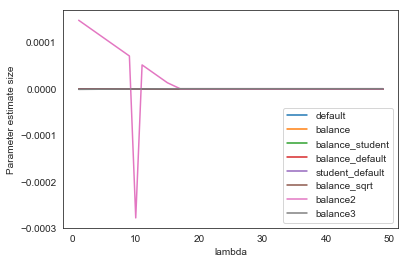

In [23]:
# Your code here
# Store estimates.
estimates = np.append(lassBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()


# Summary

Lasso and ridge regression are both clear improvements on OLS regression.  __Ridge regression is an excellent tool to use with correlated features, while __lasso is an efficient method of feature selection__ when dealing with an unmanageably large feature space. 